In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np

In [12]:
# Load the dataset
data = pd.read_csv('C://Users//LENOVO//Desktop//ProfCess//cars//train1.csv')

In [13]:
# Split features and target
X = data.drop("price", axis=1)  # Replace 'price' with your target column
y = np.log1p(data["price"])  # Apply log transformation to the target variable

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



In [14]:
# Preprocessing: Separate numerical and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(exclude=['int64', 'float64']).columns


In [15]:
# Pipelines for preprocessing
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [16]:
# Apply preprocessing to train and validation sets
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

# Simplified parameter grid with fewer options
param_grid = {
    'n_estimators': [500, 1000],  # Fewer trees
    'learning_rate': [0.1],  # Single learning rate for simplicity
    'max_depth': [3, 5],  # Reduced depth
    'subsample': [0.8],  # Single value for subsample
    'colsample_bytree': [0.8],  # Single value for colsample_bytree
    'reg_lambda': [1],  # Regularization parameter
    'reg_alpha': [0.1],  # Regularization parameter
    'min_child_weight': [3]  # Fewer values for child weight
}



In [17]:
# Define XGBoost model
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)

# Reduce the number of cross-validation folds to 2 for faster execution
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=2,  # Reduce folds to 2
                           verbose=1)

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)



Fitting 2 folds for each of 4 candidates, totalling 8 fits


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'colsample_bytree': [0.8], 'learning_rate': [0.1],
                         'max_depth': [3, 5], 'min_child_weight': [3],
                         'n_estimators': [500, 1000], 'reg_alpha': [0.1],
                         'reg_lambda': [1], 'subsample': [0.8]},
             scoring='neg_mean_squared_error', verbose=1)

In [18]:
# Best model
best_model = grid_search.best_estimator_

# Predict on the validation set
y_pred_log = best_model.predict(X_val)

# Reverse the log transformation
y_pred = np.expm1(y_pred_log)
y_val_actual = np.expm1(y_val)



In [21]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred))
print(f"Optimized XGBoost Validation RMSE: {rmse}")


Optimized XGBoost Validation RMSE: 68712.20239898389


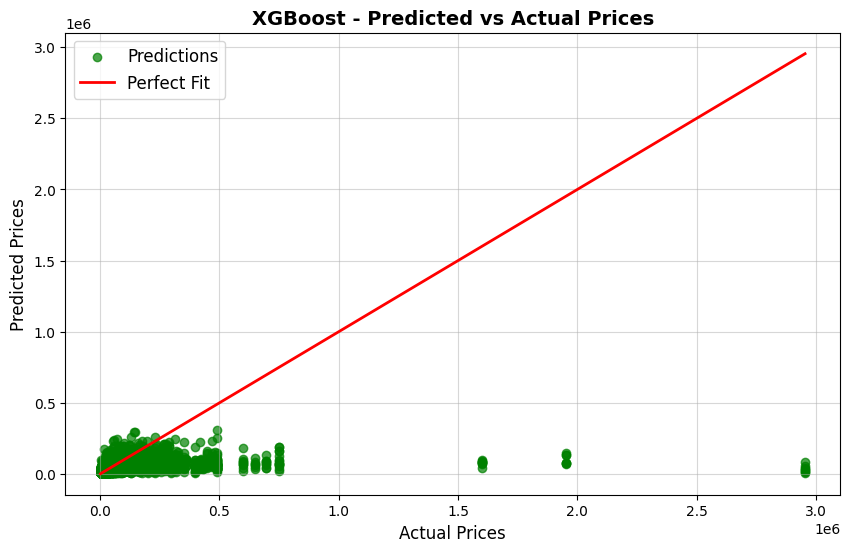

In [20]:
# Predicted vs Actual Prices (XGBoost)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_val_actual, y_pred, alpha=0.7, color='green', label='Predictions')  # Green color for predictions
plt.plot([y_val_actual.min(), y_val_actual.max()], [y_val_actual.min(), y_val_actual.max()], color='red', linewidth=2, label='Perfect Fit')  # Red line for perfect fit
plt.title('XGBoost - Predicted vs Actual Prices', fontsize=14, fontweight='bold')  # Enhanced title with bold font
plt.xlabel('Actual Prices', fontsize=12)  # Enhanced x-axis label
plt.ylabel('Predicted Prices', fontsize=12)  # Enhanced y-axis label
plt.legend(fontsize=12)  # Legend with font size
plt.grid(alpha=0.5)  # Lighter grid for better aesthetics
plt.show()
